In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline # Replaces sklearn Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# load the dataset and fix values

In [2]:
# Use the GPU
if torch.backends.mps.is_available():
    print("MPS device is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA device is available.")
    device = torch.device("cuda")
else:
    print("No GPU acceleration available.")
    device = torch.device("cpu")

# Fix the seed to have deterministic behaviour
def fix_random(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

SEED = 1337
fix_random(SEED)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

DATASET_PATH = "dataset_train/dataset.csv"
dataset = pd.read_csv(DATASET_PATH, delimiter=",")

print(f"Shape of the dataset: {dataset.shape}")
duplicates = dataset[dataset.duplicated()]
print(f"Number of duplicates in the dataset: {duplicates.shape[0]}")

MPS device is available.
Shape of the dataset: (148301, 145)
Number of duplicates in the dataset: 0


## split the dataset

In [3]:
X = dataset.drop(columns=["grade"])
y = dataset["grade"].map({"A": 6, "B": 5, "C": 4, "D": 3, "E": 2, "F": 1, "G": 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
class NumericExtractor(BaseEstimator, TransformerMixin):
    """Extracts integers from strings using regex"""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            X[col] = X[col].astype(str).str.extract(r"(\d+)").astype(float)
        return X

class CyclicalDateEncoder(BaseEstimator, TransformerMixin):
    """Converts mm-yyyy to year + sine/cosine month encoding."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            # errors="coerce" turns unparseable data/NaNs into NaT
            date_series = pd.to_datetime(X[col], format="%b-%Y", errors="coerce")
            # If date is NaT, these become NaN, which we handle in the pipeline later
            angle = 2 * np.pi * date_series.dt.month / 12

            X[f"{col}_year"] = date_series.dt.year
            X[f"{col}_month_sin"] = np.sin(angle)
            X[f"{col}_month_cos"] = np.cos(angle)
            
            X.drop(columns=[col], inplace=True)
        return X
    
class BinaryModeEncoder(BaseEstimator, TransformerMixin):
    """"Encodes 0 if value is mode, 1 if not"""
    def __init__(self):
        self.modes_ = {}

    def fit(self, X, y=None):
        # Calculate mode for each column and store it
        for col in X.columns:
            self.modes_[col] = X[col].mode()[0]
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, mode in self.modes_.items():
            # Apply: 1 if NOT the mode (least frequent), 0 if mode
            X_copy[col] = (X_copy[col] != mode).astype(int)
        return X_copy
    
class HighMissingDropper(BaseEstimator, TransformerMixin):
    """Drops columns with high missing percentage. Fits only on training data."""
    
    def __init__(self, threshold=20):
        self.threshold = threshold
        self.cols_to_drop_ = []

    def fit(self, X, y=None):
        # Calculate missing percentages only on training data
        missing_percentages = X.isna().mean() * 100
        self.cols_to_drop_ = missing_percentages[missing_percentages > self.threshold].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.cols_to_drop_)

In [5]:
redundant_cols = ['loan_title', 'loan_contract_interest_rate']
binary_cols = ["loan_payment_plan_flag", "listing_initial_status", "application_type_label",
               "hardship_flag_indicator", "disbursement_method_type", "debt_settlement_flag_indicator"]
one_hot_encoding_cols = ["borrower_housing_ownership_status", "borrower_income_verification_status",
                       "loan_status_current_code", "loan_purpose_category", "borrower_address_state"]
extract_fields = ["loan_contract_term_months", "borrower_profile_employment_length", "borrower_address_zip"]
date_fields = ["loan_issue_date", "credit_history_earliest_line", "last_payment_date", "last_credit_pull_date"]

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight

# Pipeline 1: Numerics (Extract -> Then Impute Median)
numeric_pipe = SkPipeline([
    ('extract', NumericExtractor()),
    ('impute', SimpleImputer(strategy='median')) # Handles NaNs created by extractor
])

# Pipeline 2: Categoricals (Impute "Missing" -> Then OHE)
categorical_pipe = SkPipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')), # Prevent OHE crash
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Pipeline 3: Dates (Encode -> Then Impute Median for Sin/Cos/Year)
date_pipe = SkPipeline([
    ('cyclical', CyclicalDateEncoder()),
    ('impute', SimpleImputer(strategy='median')) # Imputing sin/cos is mathematically valid
])

# Pipeline 4: Binary (Encode -> Impute)
binary_pipe = SkPipeline([
    ('binary_enc', BinaryModeEncoder()), 
    ('impute', SimpleImputer(strategy='most_frequent')) # Safety net
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipe', numeric_pipe, extract_fields),
        ('cat_pipe', categorical_pipe, one_hot_encoding_cols),
        ('date_pipe', date_pipe, date_fields),
        ('bin_pipe', binary_pipe, binary_cols),
        ('drop_redundant', 'drop', redundant_cols)
    ], 
    # Use a median imputer for any columns not listed (passthrough)
    remainder=SimpleImputer(strategy='median') 
)

pipeline = SkPipeline([
        ('dropper', HighMissingDropper(threshold=20)),
        ('prep', preprocessor),
        ('scaler', StandardScaler()), # Scale BEFORE PCA
    ])

X_clean_train = pipeline.fit_transform(X_train, y_train)
X_clean_test = pipeline.transform(X_test)

print(X_clean_train.shape)
print(X_clean_test.shape)

X_train_tensor = torch.tensor(X_clean_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_clean_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

y_train_tensor = y_train_tensor.long()
y_test_tensor = y_test_tensor.long()

# Create Datasets and DataLoaders for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 2. Calculate Class Weights ---
# We calculate weights to handle class imbalance (inverse frequency)
# Assuming y_train_tensor contains class indices 0-6
y_train_np = y_train_tensor.numpy()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)

# Convert weights to a tensor and move to device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f"Computed Class Weights: {class_weights_tensor}")

(118640, 172)
(29661, 172)
Computed Class Weights: tensor([3.4823, 2.8158, 1.7534, 0.9966, 0.5713, 0.5614, 0.7984])


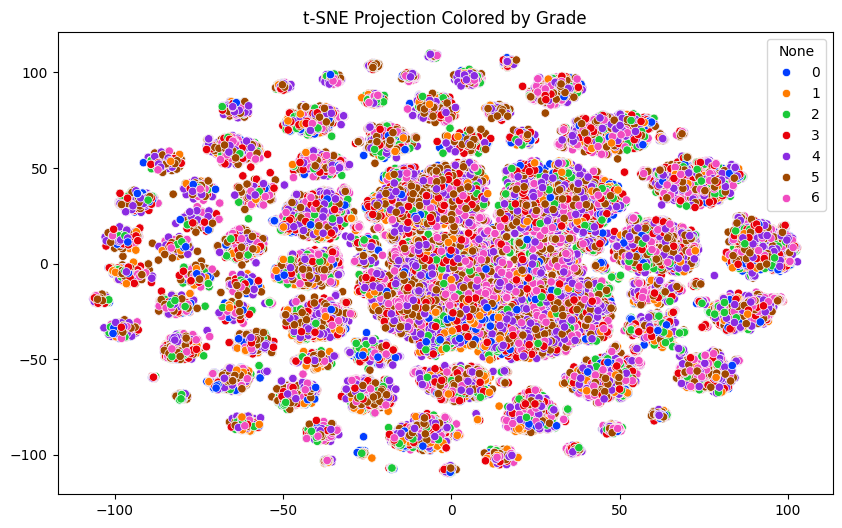

In [8]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare data (dropping the target column 'grade')

# 2. Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train_tensor)

# 3. Plot and color by grade
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_train_tensor, palette='bright')
plt.title('t-SNE Projection Colored by Grade')
plt.show()

In [20]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        
        # Define the architecture
        self.network = nn.Sequential(
            # Input Layer -> Hidden Layer 1
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),      # Batch Normalization
            nn.ReLU(),
            nn.Dropout(0.1),          # Dropout 0.1

            # Hidden Layer 1 -> Hidden Layer 2
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),       # Batch Normalization
            nn.ReLU(),
            nn.Dropout(0.1),          # Dropout 0.1
            
            # Hidden Layer 2 -> Output Layer (7 Categories)
            nn.Linear(64, output_dim) 
        )

    def forward(self, x):
        return self.network(x)

# Initialize Model
input_features = X_train_tensor.shape[1]
output_categories = 7

model = FeedForwardNN(input_features, output_categories).to(device)
print(model)

FeedForwardNN(
  (network): Sequential(
    (0): Linear(in_features=172, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=7, bias=True)
  )
)


In [21]:
# --- Configuration ---
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

# --- Training Loop ---
model.train()  # Set model to training mode (enables Dropout/BatchNorm)

model.to(device)

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/50], Loss: 1.2837, Accuracy: 45.88%
Epoch [2/50], Loss: 1.0729, Accuracy: 55.42%
Epoch [3/50], Loss: 1.0074, Accuracy: 58.31%
Epoch [4/50], Loss: 0.9672, Accuracy: 60.10%
Epoch [5/50], Loss: 0.9434, Accuracy: 60.95%
Epoch [6/50], Loss: 0.9202, Accuracy: 62.08%
Epoch [7/50], Loss: 0.9034, Accuracy: 62.50%
Epoch [8/50], Loss: 0.8944, Accuracy: 63.19%
Epoch [9/50], Loss: 0.8781, Accuracy: 63.70%
Epoch [10/50], Loss: 0.8701, Accuracy: 63.80%
Epoch [11/50], Loss: 0.8598, Accuracy: 64.42%
Epoch [12/50], Loss: 0.8497, Accuracy: 64.84%
Epoch [13/50], Loss: 0.8444, Accuracy: 64.96%
Epoch [14/50], Loss: 0.8342, Accuracy: 64.95%
Epoch [15/50], Loss: 0.8292, Accuracy: 65.46%
Epoch [16/50], Loss: 0.8260, Accuracy: 65.56%
Epoch [17/50], Loss: 0.8182, Accuracy: 65.92%
Epoch [18/50], Loss: 0.8126, Accuracy: 65.92%
Epoch [19/50], Loss: 0.8084, Accuracy: 65.99%
Epoch [20/50], Loss: 0.8012, Accuracy: 66.53%
Epoch [21/50], Loss: 0.7968, Accuracy: 66.40%
Epoch [22/50], Loss: 0.7944, Accuracy: 66.5

In [22]:
# 1. Set model to evaluation mode
model.eval()

# 2. Disable gradient calculation for memory efficiency
with torch.no_grad():
    # Move test data to the same device as the model (CPU or GPU)
    X_test_tensor = X_test_tensor.to(device)
    
    # Forward pass
    outputs = model(X_test_tensor)
    
    # 3. Get predicted classes
    # For CrossEntropy (7 classes), we take the index of the highest logit
    _, y_pred_tensor = torch.max(outputs, 1)
    
    # 4. Convert to NumPy for Scikit-Learn
    # Ensure it's on CPU before converting to numpy
    y_pred = y_pred_tensor.cpu().numpy()
    
# 5. Calculate and print metrics
# Note: y_test should be your original labels or y_test_tensor.cpu().numpy()
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

bacc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bacc:.4f}")

f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.7352
Balanced Accuracy: 0.7004
F1 score: 0.7352


--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.58      0.73      0.64      1217
     Class 1       0.52      0.47      0.49      1505
     Class 2       0.64      0.62      0.63      2417
     Class 3       0.65      0.75      0.69      4251
     Class 4       0.75      0.72      0.74      7416
     Class 5       0.80      0.72      0.76      7548
     Class 6       0.86      0.89      0.87      5307

    accuracy                           0.74     29661
   macro avg       0.68      0.70      0.69     29661
weighted avg       0.74      0.74      0.74     29661



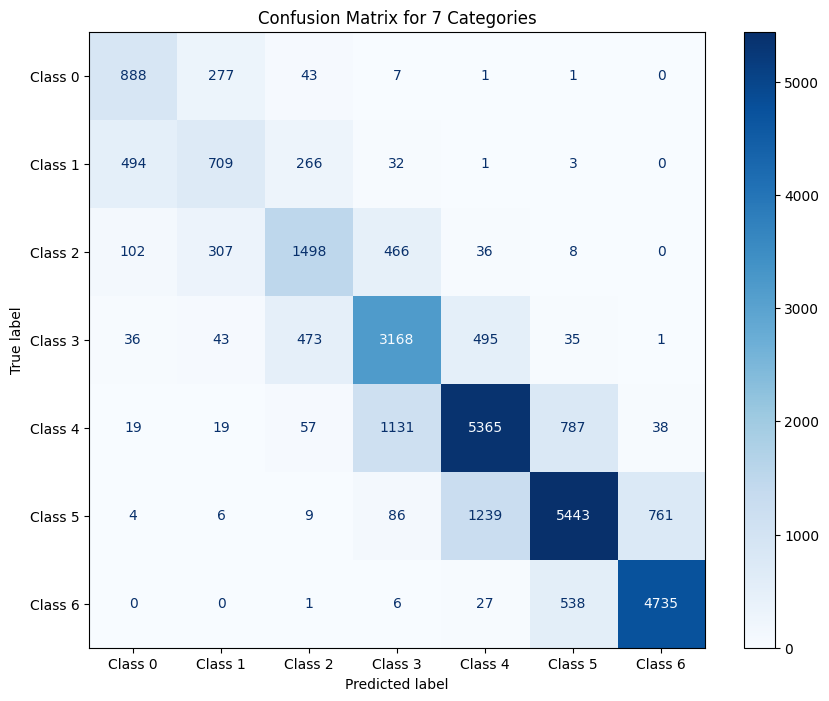

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare the data (Ensure everything is on CPU and numpy format)
# y_test_tensor might still be on GPU or a Tensor, so we convert it
y_true = y_test_tensor.cpu().numpy()

# Optional: Define your class names (0 to 6) for the plot
class_names = [f'Class {i}' for i in range(7)] 
# If you know the specific names, replace above with:
# class_names = ['Low', 'Medium', 'High', 'Critical', etc...]

# 2. Generate Classification Report (Precision, Recall, F1-Score)
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Generate and Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, values_format='d') # values_format='d' suppresses scientific notation

plt.title('Confusion Matrix for 7 Categories')
plt.show()